# Imports

In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import xarray as xr
import os
import cmlreaders as cml

# Signal Processing
from scipy import signal
import mne

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# File Loading
import pyedflib
import pathlib
import h5py 
import pickle

# Miscellaneous
from typing import Union, Dict, List, Set, Tuple, Callable
import cmldask.CMLDask as da
import cmldask

In [3]:
def z_score(mx, axis = -1):
    
    mean = np.mean(mx, axis)
    std = np.std(mx, axis)
    mx = np.moveaxis(mx, axis, -1)
    mxz = np.divide(np.subtract(mx[...,0], mean), std)
    
    return mxz

def load_pickle(path):
    
    with open(path, 'rb') as f:
        return pickle.load(f)

def save_pickle(path, obj):
    
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    
def load_mat(path):
    
    try:
        return scipy.io.loadmat(path)
    except:
        f = h5py.File(path, 'r') #can use .keys() and .get('{key}') methods in order to get stuff from it
        return f

def load_micro_lfp(sub, sess, chan, exp):
    
    if exp=='gm':
        path = f'/data7/goldmine/data/{sub}/ses{sess}/micro_lfps/sr1000_bandpass0.1-80_notch60/CSC{chan}.pkl'
    if exp=='ycab':
        path = f'/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab/eeg/{sub}/ses{sess}/micro_lfps/V-to-muV_sr1000_bandpass0.1-80_notch60/CSC{chan}.pkl'
    
    return load_pickle(path)[0]

def mean_sem(values,axis=0):
    
    if len(values.shape) == 1: values = np.array([values]).T
    mean = np.mean(values, axis=axis)
    sem = scipy.stats.sem(values, axis=axis)
    df = pd.DataFrame(np.array([mean, sem]).T, columns=['mean', 'sem']) 
    df['lower'] = df['mean'] - df['sem']
    df['upper'] = df['mean'] + df['sem']
    
    return df

# Get dataset

In [ ]:
rois = {'A': 'A',
        'AC': 'PFC',
        'AH': 'HPC',
        'AI': 'O',
        'AO': 'O',
        'AT': 'O',
        'EC': 'EC',
        'FOp': 'PFC',
        'FOP': 'PFC',
        'FSG': 'O',
        'HGa': 'O',
        'I': 'O',
        'IP': 'O',
        'IPO': 'O',
        'MC': 'PFC',
        'MFG': 'PFC',
        'MH': 'HPC',
        'MI': 'O',
        'mOCC': 'O',
        'MO': 'O',
        'MST': 'O',
        'O': 'O',
        'OF': 'PFC',
        'PC': 'O',
        'PG': 'O',
        'PH': 'HPC',
        'PI': 'O',
        'PHG': 'O',
        'PI-SMG': 'PFC',
        'PI_SMG': 'PFC',
        'PO': 'O',
        'POp': 'O',
        'POSTI': 'O',
        'PS': 'O',
        'PST': 'O',
        'pSMA': 'PFC',
        'SAO': 'O',
        'SMA': 'PFC',
        'ST': 'O',
        'STS': 'O',
        'TO': 'O',
        'TP': 'O',
        'TPO': 'O'}

In [1]:
def parse_osc_mask_fname(fname):
    
    sub = fname.split('.npy')[0].split('_')[0]
    sess = fname.split('.npy')[0].split('ses')[-1].split('-')[0]
    reg = fname.split('.npy')[0].split('-')[-1]
    
    return sub, sess, reg

In [4]:
ycab_osc_mask_list = os.listdir('/home1/amrao/SUPL/files/oscillation_detection/osc_masks_ycab_dan')
gm_osc_mask_list = os.listdir('/home1/amrao/SUPL/files/oscillation_detection/osc_masks_gm_dan')

In [14]:
ycab_list = []
for fname in ycab_osc_mask_list:
    sub, sess, reg = parse_osc_mask_fname(fname)
    ycab_list.append([sub, 'ycab', sess, reg])
    
gm_list = []
for fname in gm_osc_mask_list:
    sub, sess, reg = parse_osc_mask_fname(fname)
    gm_list.append([sub, 'gm', sess, reg])

slist = np.vstack([ycab_list, gm_list])
slist = pd.DataFrame(slist, columns=['sub', 'exp', 'sess', 'reg'])
HPC = slist.apply(lambda x: rois[x.reg[1:]] == 'HPC', axis=1)
slist.insert(len(slist.columns), 'HPC', HPC)

In [290]:
chans = []
for i, r in slist.iterrows():
    
    sub, exp, sess, reg = r[['sub', 'exp', 'sess', 'reg']]
    chans_dir = f'/home1/amrao/SUPL/files/oscillation_detection/osc_masks_{exp}_dan/chans'
    chan = np.load(f'{chans_dir}/{sub}_ses{sess}-{reg}_chans.npy', allow_pickle=True)
    chans.append(chan)
slist.insert(len(slist.columns), 'chan', chans)
slistchan = slist.explode('chan')
slistchan.to_csv('/home1/amrao/SUPL/files/slistchan.csv')
slistchanHPCdf = slistchan.query('HPC == True').reset_index()

In [29]:
slistchan = pd.read_csv('/home1/amrao/SUPL/files/slistchan.csv', index_col=0)

In [33]:
slistchanHPC = slistchan.query('HPC == True').reset_index()

# Oscillatory bout co-occurrence

In [8]:
def get_bout_cooccurrence(seq1, seq2, obs_no=499):
    
    assert seq1.shape == seq2.shape
    cooccurrence = (2*np.sum(np.logical_and(seq1, seq2).astype(bool)))/(np.sum(seq1) + np.sum(seq2))
    
    if obs_no > 0:
        null_distribution = [get_bout_cooccurrence(seq1, np.roll(seq2, np.random.randint(0, seq2.shape[-1]), axis=-1), obs_no=0) for x in range(obs_no)]
        cooccurrence = np.hstack([[cooccurrence], null_distribution])
        
    return cooccurrence

In [9]:
def find_harmonic_bout_cooccurrences_ycab(osc_mask_fname, freqs = [3, 7, 15], obs_no=499, overwrite=False):
    
    load_dir = '/home1/amrao/SUPL/files/oscillation_detection/osc_masks_ycab_dan'
    save_dir = '/home1/amrao/SUPL/files/oscillation_detection/bout_cooccurrences_ycab_dan'
    save_fname = osc_mask_fname.split('_oscillation_mask')[0] + '_bout_cooccurrence.pkl'
    
    if not overwrite:
        if os.path.exists(f'{save_dir}/{save_fname}'): return

    osc_mask = np.load(f'{load_dir}/{osc_mask_fname}', allow_pickle=True)
    all_freqs = np.arange(1, 31)
    osc_mask = xr.DataArray(osc_mask, dims=['event', 'chan', 'freq', 'time'], 
                            coords={'event': (['event'], np.arange(osc_mask.shape[0])), 'chan': (['chan'], np.arange(osc_mask.shape[1])), 
                                    'freq': (['freq'], all_freqs), 'time': (['time'], np.arange(osc_mask.shape[3]))})
    cooccurrences = []
    for freq1 in freqs: 
        cooccurrence = [get_bout_cooccurrence(osc_mask.sel(freq = freq1), osc_mask.sel(freq = freq2), obs_no=obs_no) 
                        for freq2 in all_freqs]
        cooccurrences.append(cooccurrence)
        
    cooccurrences = np.asarray(cooccurrences)
    
    cooccurrences = xr.DataArray(cooccurrences, dims=['freq1', 'freq2', 'perm'], 
                                 coords={'freq1': (['freq1'], freqs), 'freq2': (['freq2'], all_freqs), 
                                         'perm': np.arange(obs_no+1)})
    
    with open(f'{save_dir}/{save_fname}', 'wb') as file:
        pickle.dump(cooccurrences, file)
    file.close()
    

In [11]:
def find_harmonic_bout_cooccurrences_gm(osc_mask_fname, freqs = [3, 7, 15], obs_no=499, overwrite=False):
    
    load_dir = '/home1/amrao/SUPL/files/oscillation_detection/osc_masks_gm_dan'
    save_dir = '/home1/amrao/SUPL/files/oscillation_detection/bout_cooccurrences_gm_dan'
    save_fname = osc_mask_fname.split('_oscillation_mask')[0] + '_bout_cooccurrence.pkl'
    
    if not overwrite:
        if os.path.exists(f'{save_dir}/{save_fname}'): return

    osc_mask = np.load(f'{load_dir}/{osc_mask_fname}', allow_pickle=True)
    all_freqs = np.arange(1, 31)
    osc_mask = xr.DataArray(osc_mask, dims=['event', 'chan', 'freq', 'time'], 
                            coords={'event': (['event'], np.arange(osc_mask.shape[0])), 'chan': (['chan'], np.arange(osc_mask.shape[1])), 
                                    'freq': (['freq'], all_freqs), 'time': (['time'], np.arange(osc_mask.shape[3]))})
    cooccurrences = []
    for freq1 in freqs: 
        cooccurrence = [get_bout_cooccurrence(osc_mask.sel(freq = freq1), osc_mask.sel(freq = freq2), obs_no=obs_no) 
                        for freq2 in all_freqs]
        cooccurrences.append(cooccurrence)
        
    cooccurrences = np.asarray(cooccurrences)
    
    cooccurrences = xr.DataArray(cooccurrences, dims=['freq1', 'freq2', 'perm'], 
                                 coords={'freq1': (['freq1'], freqs), 'freq2': (['freq2'], all_freqs), 
                                         'perm': np.arange(obs_no+1)})
    
    with open(f'{save_dir}/{save_fname}', 'wb') as file:
        pickle.dump(cooccurrences, file)
    file.close()
    

# Asymmetric waveform analysis

## LFP epoching based on oscillation mask epoching

In [ ]:
def osc_masks_gm_events(load_fname):
    
    load_dir = '/scratch/dscho/goldmine/nav/p_episode/'
    save_dir = '/home1/amrao/SUPL/files/oscillation_detection/osc_masks_gm_dan/events'
    save_fname = load_fname.split('.pkl')[0] + '_events.npy'
    A = load_pickle(load_dir + load_fname)
    evs = A.event.values
    np.save(os.path.join(save_dir, save_fname), evs)

In [ ]:
def osc_masks_ycab_events():
    
    load_dir = '/scratch/dscho/ycab/p_episode/'
    save_dir = '/home1/amrao/SUPL/files/oscillation_detection/osc_masks_ycab_dan/events'
    save_fname = f.split('.npy')[0] + '_events.npy'
    A = load_pickle(load_dir + f)
    evs = A.event.values
    np.save(os.path.join(save_dir, save_fname), evs)

In [ ]:
def get_gm_times(sub, sess):
    
    events = load_pickle(f'/home1/dscho/projects/time_cells/analysis/events/{sub}_ses{sess}-events_formatted.pkl')
    gm_times = []
    for x in itertools.product(['Encoding', 'Retrieval'], np.arange(1, 37)):
        gs, trial = x
        start = events.query('trial == @trial and gameState == @gs').time.values[0]
        gm_times.append(pd.DataFrame([[trial, gs, start]], columns=['trial', 'gameState', 'start_time']))
    gm_times = pd.concat(gm_times,axis=0)
    gm_times['stop_time'] = gm_times['start_time'] + 30000
    return gm_times

In [ ]:
def get_gm_times_match_mask(sub, sess, chan):
    
    gm_times = get_gm_times(sub, sess)
    evs_dir = '/home1/amrao/SUPL/files/oscillation_detection/osc_masks_gm_dan/events/'
    reg = slistchan.query('sub == @sub and exp == "gm" and sess == @sess and chan == @chan').reg.values[0]
    evs = np.load(evs_dir + f'{sub}_ses{sess}-{reg}_events.npy', allow_pickle=True)
    gm_times_list = []
    for ev in evs:
        gs, trial = ev
        r = gm_times.query('trial == @trial and gameState == @gs')
        gm_times_list.append(r)
    gm_times = pd.concat(gm_times_list)
    return gm_times

In [ ]:
def get_ycab_times(sub, sess):
    
    x = load_pickle(f'/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab/events/{sub}_ses{sess}-event_times.pkl')
    return x

In [ ]:
def epoch_lfp(lfp, event_times):
    
    lfp_epoched = np.array([lfp[r.start_time:r.stop_time] for i, r in event_times.iterrows()])
    return lfp_epoched

In [ ]:
def save_epoched_lfp(r):
    
    sub, sess, chan, exp = r
    lfp = load_micro_lfp(sub, sess, chan, exp)
    freq = 3
    filt_lfp = mne.filter.filter_data(lfp, sfreq=1000, l_freq=freq-2, h_freq=freq+2, verbose=False)
    if exp == 'ycab': 
        event_times = get_ycab_times(sub, sess)
    elif exp == 'gm':
        event_times = get_gm_times_match_mask(sub, sess, chan)
    lfp_epoched = epoch_lfp(lfp, event_times)
    filt_lfp_epoched = epoch_lfp(lfp, event_times)
    np.save(f'/home1/amrao/SUPL/files/oscillation_detection/epoched_lfp_{exp}/{sub}_ses{sess}_CSC{chan}_lfp.npy',
           lfp_epoched)
    np.save(f'/home1/amrao/SUPL/files/oscillation_detection/epoched_filt_lfp_{exp}/{sub}_ses{sess}_CSC{chan}_filt_lfp.npy',
           filt_lfp_epoched)
    

In [ ]:
def save_epoched_lfp(r):
    
    sub, sess, chan, exp = r
    lfp = load_micro_lfp(sub, sess, chan, exp)
    freqs = [3, 7, 15]
    for freq in freqs:
        filt_lfp = mne.filter.filter_data(lfp, sfreq=1000, l_freq=freq-2, h_freq=freq+2, verbose=False)
        if exp == 'ycab': 
            event_times = get_ycab_times(sub, sess)
        elif exp == 'gm':
            event_times = get_gm_times_match_mask(sub, sess, chan)
        filt_lfp_epoched = epoch_lfp(lfp, event_times)
        np.save(f'/home1/amrao/SUPL/files/oscillation_detection/epoched_filt_lfp_{exp}/{sub}_ses{sess}_CSC{chan}_filt_lfp_freq{freq}.npy',
               filt_lfp_epoched)
    

## Asymmetry calculation

In [190]:
def find_peaks(filt_lfp, freq, sr):

    interpeak_distance = np.ceil((sr/freq)*0.5)
    peaks = scipy.signal.find_peaks(x=filt_lfp, distance=interpeak_distance)[0]
    troughs = scipy.signal.find_peaks(x=np.multiply(-1, filt_lfp), distance=interpeak_distance)[0]
    return peaks, troughs

def match_peaks(lfp, peaks, troughs, freq, sr, search_width=0.55):
    
    search_window = (search_width*np.ceil((sr/freq)/4)).astype(int)

    adjusted_peaks = np.asarray([scipy.signal.find_peaks(x=lfp[(peak-search_window):(peak+search_window+1)], 
                                                         distance=2*search_window)[0]+(peak-search_window) 
                      for peak in peaks])
    adjusted_peaks = np.squeeze([x for x in adjusted_peaks if len(x)>0])

    adjusted_troughs = np.asarray([scipy.signal.find_peaks(x=np.multiply(-1, lfp)[(trough-search_window):(trough+search_window+1)], 
                                                           distance=2*search_window)[0]+(trough-search_window) 
                      for trough in troughs])
    
    adjusted_troughs = np.squeeze([x for x in adjusted_troughs if len(x)>0])

    return adjusted_peaks, adjusted_troughs

def match_peak_to_trough(adjusted_peaks, adjusted_troughs, osc_mask, freq, sr):
    
    def add_dt(dTs, a, b, c, osc_mask):
        
        if not np.any(osc_mask):
            dT = (c - b) - (b - a)
            dTs.append(dT)
            return dTs
        elif (osc_mask[a]) & (osc_mask[b]) & (osc_mask[c]): 
            dT = (c - b) - (b - a)
            dTs.append(dT)
            return dTs
        else: return dTs
    
    dTs = []
    extra_peaks = 0; extra_troughs = 0
    
    for iPeak, peak in enumerate(adjusted_peaks):
        
        if len(adjusted_troughs) <= iPeak+extra_troughs-extra_peaks+2: break
                
        next_trough = adjusted_troughs[iPeak+extra_troughs-extra_peaks]
        next_peak = adjusted_peaks[iPeak+1]
        nextnext_trough = adjusted_troughs[iPeak+1+extra_troughs-extra_peaks]
            
        if np.all([next_trough, next_peak, nextnext_trough] == np.sort([next_trough, next_peak, nextnext_trough])):
            dTs = add_dt(dTs, peak, next_trough, next_peak, osc_mask)
        elif next_peak < next_trough: extra_peaks += 1
        elif nextnext_trough < next_peak: extra_troughs += 1

    return dTs

def drop_edge_troughs(adjusted_peaks, adjusted_troughs):
    
    if adjusted_peaks[0] > adjusted_troughs[0]: adjusted_troughs = adjusted_troughs[1:]
    if adjusted_troughs[-1] > adjusted_peaks[-1]: adjusted_troughs = adjusted_troughs[:(len(adjusted_troughs)-1)]

    return adjusted_peaks, adjusted_troughs

def calculate_asymmetry(adjusted_peaks, adjusted_troughs, freq, sr):
    
    T_asc = np.asarray([adjusted_peaks[t + 1] - adjusted_troughs[t] for t in range(len(adjusted_troughs))])
    T_desc = np.asarray([adjusted_troughs[t] - adjusted_peaks[t] for t in range(len(adjusted_troughs))])
    return T_asc, T_desc

def calculate_ai(lfp, filt_lfp, osc_mask=None, freq=3, sr=1000):
    
    peaks, troughs = find_peaks(filt_lfp, freq=freq, sr=sr)
    adjusted_peaks, adjusted_troughs = match_peaks(lfp, peaks, troughs, freq=freq, sr=sr, search_width=0.55)
    adjusted_peaks, adjusted_troughs = drop_edge_troughs(adjusted_peaks, adjusted_troughs)
    dTs = match_peak_to_trough(adjusted_peaks, adjusted_troughs, osc_mask, freq=freq, sr=sr)
    ai = np.mean(dTs)/(sr/freq)
    return ai

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def run_ai(slistchanrow):
    
    sub, exp, sess, chan, reg = slistchanrow
    
    lfp_dir = f'/home1/amrao/SUPL/files/oscillation_detection/epoched_lfp_{exp}'
    lfp = np.load(os.path.join(lfp_dir, f'{sub}_ses{sess}_CSC{chan}_lfp.npy'), allow_pickle=True)

    for freq in [3, 7, 15]:
        
        filt_lfp_dir = f'/home1/amrao/SUPL/files/oscillation_detection/epoched_filt_lfp_{exp}'
        filt_lfp = np.load(os.path.join(filt_lfp_dir, f'{sub}_ses{sess}_CSC{chan}_filt_lfp_freq{freq}.npy'), allow_pickle=True)
    
        chans_path = f'/home1/amrao/SUPL/files/oscillation_detection/osc_masks_{exp}_dan/chans/{sub}_ses{sess}-{reg}_chans.npy'
        chans = np.load(chans_path, allow_pickle=True)
        iChan = np.where(chans == chan)[0][0]
        
        osc_mask_path = f'/home1/amrao/SUPL/files/oscillation_detection/osc_masks_{exp}_dan/{sub}_ses{sess}-{reg}.npy'
        osc_mask = np.load(osc_mask_path, allow_pickle=True)
        osc_mask = osc_mask[:, iChan, freq-1, :]
    
        ais = []
        for iEv in np.arange(lfp.shape[0]):
            ai = calculate_ai(lfp[iEv, :], filt_lfp[iEv, :], osc_mask[iEv, :], freq=freq, sr=1000)
            ais.append(ai)
        ai = np.nanmean(ais)
        
        save_dir = f'/home1/amrao/SUPL/files/oscillation_detection/ai_{exp}'
        fname = f'{sub}_ses{sess}_CSC{chan}_ai_osc_freq{freq}.npy'
        np.save(os.path.join(save_dir, fname), ai)
        
        ais = []
        for iEv in np.arange(lfp.shape[0]):
            ai = calculate_ai(lfp[iEv, :], filt_lfp[iEv, :], None, freq=freq, sr=1000)
            ais.append(ai)
        ai = np.nanmean(ais)
        
        save_dir = f'/home1/amrao/SUPL/files/oscillation_detection/ai_{exp}'
        fname = f'{sub}_ses{sess}_CSC{chan}_ai_ws_freq{freq}.npy'
        np.save(os.path.join(save_dir, fname), ai)

# Visualization of first three oscillatory bouts

In [ ]:
sub, sess, chan, exp = slistchan.query('HPC == True')[['sub', 'sess', 'chan', 'exp']].iloc[0]

In [ ]:
def average_bout(sub, sess, chan, exp, freq):
    three_bout_length = int(3*1000/freq)
    lfp_path = f'/home1/amrao/SUPL/files/oscillation_detection/epoched_lfp_{exp}'
    lfp = np.load(os.path.join(lfp_path, f'{sub}_ses{sess}_CSC{chan}_lfp.npy'), allow_pickle=True)
    osc_mask_path = f'/home1/amrao/SUPL/files/oscillation_detection/osc_masks_{exp}_dan'
    reg = slistchan.query('sub == @sub and exp == @exp and sess == @sess and chan == @chan').reg.values[0]
    osc_mask = np.load(os.path.join(osc_mask_path, f'{sub}_ses{sess}-{reg}.npy'), allow_pickle=True)
    chans = np.load(os.path.join(osc_mask_path, f'chans/{sub}_ses{sess}-{reg}_chans.npy'), allow_pickle=True)
    iChan = np.where(chans == chan)[0][0]
    osc_mask = osc_mask[:, iChan, freq-1, :]
    osc_mask = np.array(osc_mask, dtype='int32')
    bout_starts_ = []
    for ev in osc_mask:
        bout_starts = np.where(np.diff(ev) == 1)[0] + 1
        if ev[0] == 1: bout_starts = np.insert(bout_starts, 0, 0)
        bout_starts_.append(bout_starts)
    bouts = []
    for iEv, ev_bout_starts in enumerate(bout_starts_):
        this_lfp = lfp[iEv, :]
        for bs in ev_bout_starts:
            bout = this_lfp[bs:(bs+three_bout_length)]
            if len(bout) >= three_bout_length: bouts.append(bout)
    median_bout = np.median(bouts, axis=0)
    mean_bout = np.mean(bouts, axis=0)
    save_dir = f'/home1/amrao/SUPL/files/oscillation_detection/median_bouts_{exp}'
    save_fname = f'{sub}_ses{sess}_CSC{chan}_median_bout_freq{freq}.npy'
    np.save(os.path.join(save_dir, save_fname), median_bout)
    save_dir = f'/home1/amrao/SUPL/files/oscillation_detection/mean_bouts_{exp}'
    save_fname = f'{sub}_ses{sess}_CSC{chan}_mean_bout_freq{freq}.npy'
    np.save(os.path.join(save_dir, save_fname), mean_bout)

In [ ]:
def run_average_bout(r):
    
    sub, sess, chan, exp = r
    for freq in [3, 7, 15]: average_bout(sub, sess, chan, exp, freq)

In [ ]:
client = da.new_dask_client_slurm('rab', '10GB', 80)
futures = client.map(run_average_bout, slistchansel)

In [ ]:
slistchansel = slistchan.query('HPC == True')[['sub', 'sess', 'chan', 'exp']].to_numpy()

# Compiling results


In [47]:
slistchanHPCdf = pd.read_csv('/home1/amrao/SUPL/files/slistchan.csv', index_col=0).query('HPC == True').reset_index()

In [48]:
dices = []; dice_zs = []
for i, r in slistchanHPCdf.iterrows():
    
    sub, sess, chan, exp, reg = r[['sub', 'sess', 'chan', 'exp', 'reg']]
    save_dir = f'/home1/amrao/SUPL/files/oscillation_detection/bout_cooccurrences_{exp}_dan'
    cooc = load_pickle(f'{save_dir}/{sub}_ses{sess}-{reg}.npy_bout_cooccurrence.pkl')
    dice = cooc.sel(perm = 0).values
    dice_z = z_score(cooc.values)
    dice = [dice[i, :] for i in np.arange(dice.shape[0])]
    dice_z = [dice_z[i, :] for i in np.arange(dice_z.shape[0])]
    dices.append(dice)
    dice_zs.append(dice_z)

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [49]:
dices = pd.DataFrame(dices, columns=['dice3', 'dice7', 'dice15'])
dice_zs = pd.DataFrame(dice_zs, columns=['dicez3', 'dicez7', 'dicez15'])

In [50]:
slistchanHPCcooc = pd.concat([slistchanHPCdf, dices], axis=1)
slistchanHPCcooc = pd.concat([slistchanHPCcooc, dice_zs], axis=1)

In [51]:
all_mean_bouts = []
for i, r in slistchanHPCdf.iterrows():
    sub, sess, chan, exp = r[['sub', 'sess', 'chan', 'exp']]
    mean_bouts = []
    for freq in [3, 7, 15]:
        b = np.load(f'/home1/amrao/SUPL/files/oscillation_detection/mean_bouts_{exp}/{sub}_ses{sess}_CSC{chan}_mean_bout_freq{freq}.npy', allow_pickle=True)
        mean_bouts.append(b)
    all_mean_bouts.append(mean_bouts)
all_mean_bouts = np.asarray(all_mean_bouts)
all_mean_bouts = pd.DataFrame(all_mean_bouts, columns=['meanb_3', 'meanb_7', 'meanb_15'])

/usr/global/miniconda/py310_23.1.0-1/envs/workshop/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [52]:
slistchanHPCcooc = pd.concat([slistchanHPCcooc, all_mean_bouts[['meanb_3', 'meanb_7', 'meanb_15']]], axis=1)

In [53]:
aisosc3 = []; aisosc7 = []; aisosc15 = []
for i, r in slistchanHPCdf.iterrows():
    sub, exp, sess, chan = r[['sub', 'exp', 'sess', 'chan']]
    ai3 = np.load(f'/home1/amrao/SUPL/files/oscillation_detection/ai_{exp}/{sub}_ses{sess}_CSC{chan}_ai_osc_freq3.npy', allow_pickle=True)
    ai7 = np.load(f'/home1/amrao/SUPL/files/oscillation_detection/ai_{exp}/{sub}_ses{sess}_CSC{chan}_ai_osc_freq7.npy', allow_pickle=True)
    ai15 = np.load(f'/home1/amrao/SUPL/files/oscillation_detection/ai_{exp}/{sub}_ses{sess}_CSC{chan}_ai_osc_freq15.npy', allow_pickle=True)
    aisosc3.append(ai3.item()); aisosc7.append(ai7.item()); aisosc15.append(ai15.item())

In [54]:
for x, y in zip(['ai_osc_3', 'ai_osc_7', 'ai_osc_15'], [aisosc3, aisosc7, aisosc15]):
    slistchanHPCcooc.insert(len(slistchanHPCcooc.columns), x, y)

In [56]:
save_pickle('/home1/amrao/SUPL/files/oscillation_detection/slistchanHPCcooc.pkl', slistchanHPCcooc)

# Visualization

## Set parameters

In [4]:
from collections import OrderedDict as od

In [5]:
import numpy as np
import xarray
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
from scipy import signal
from scipy.io import loadmat
import h5py
import sys
import os
import os.path as op
import glob

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
from formatting import *

In [8]:
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

In [9]:
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')

In [10]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

## Dice

In [45]:
slistchanHPCcooc = load_pickle('/home1/amrao/SUPL/files/oscillation_detection/slistchanHPCcooc.pkl')
dice_df = slistchanHPCcooc[['sub', 'sess', 'chan', 'reg', 'dice3', 'dice7', 'dice15']].copy()

In [46]:
# Average over channels within a HPC region, over HPC regions within a session, and over sessions within a subject
dice3 = dice_df.groupby(['sub', 'sess', 'reg']).dice3.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean()
dice7 = dice_df.groupby(['sub', 'sess', 'reg']).dice7.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean()
dice15 = dice_df.groupby(['sub', 'sess', 'reg']).dice15.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean()

In [47]:
dice3a = np.array([x for x in dice3.to_numpy()])
dice7a = np.array([x for x in dice7.to_numpy()])
dice15a = np.array([x for x in dice15.to_numpy()])

In [48]:
dice3a = mean_sem(dice3a)
dice7a = mean_sem(dice7a)
dice15a = mean_sem(dice15a)

In [49]:
freqs = np.arange(1, 31)

In [50]:
is_local = 0
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 8, 'label': 7, 'fig': 8, 'annot': 6}
ax_linewidth = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [1, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (0, 1)
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
yticklabs = yticks
lw = 1
plot_hline = 1
hline = 0
hline_color = co['k']
plot_labels = False

In [51]:
mpl.__version__

'3.7.2'

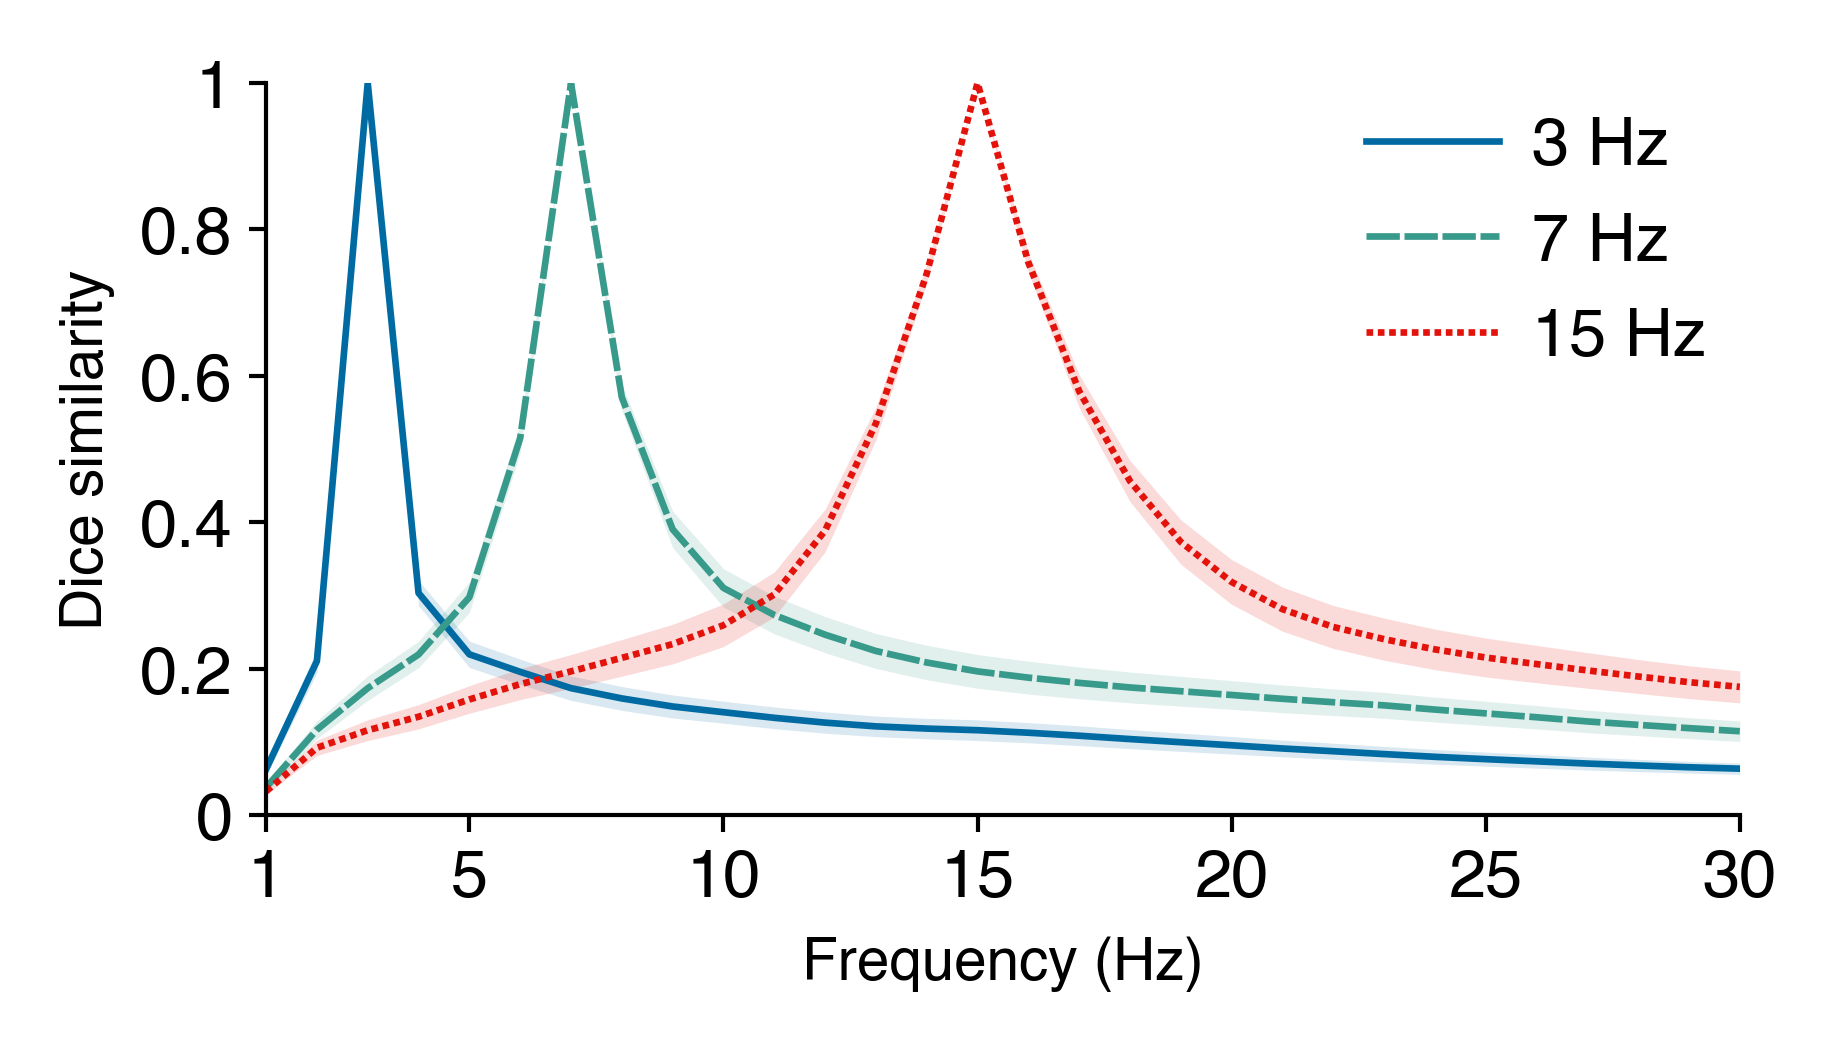

In [52]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(ax_linewidth)
ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('Dice similarity', fontsize=font['label'], labelpad=labelpad)
for vals, color, linestyle, label in zip([dice3a, dice7a, dice15a], 
                                         ['#006BA2', '#379A8B', '#E3120B'],
                                         ['solid', (0, (5, 0.7)), (0, (1, 0.7))],
                                         ['3 Hz', '7 Hz', '15 Hz']):
    line, = ax.plot(freqs, vals['mean'].to_numpy(),color=color,linestyle=linestyle)
    ax.fill_between(freqs, vals['upper'].to_numpy(), vals['lower'].to_numpy(), alpha=0.15, lw=0, color=color)
    line.set_label(label)
ax.legend(fontsize=8, handletextpad=0.5)

## Dice_z

In [213]:
slistchanHPCcooc = load_pickle('/home1/amrao/SUPL/files/oscillation_detection/slistchanHPCcooc.pkl')
dicez_df = slistchanHPCcooc[['sub', 'sess', 'chan', 'reg', 'dicez3', 'dicez7', 'dicez15']].copy()

In [214]:
# aggregation that handles NaN values
dicez = []
for i in ['dicez3', 'dicez7', 'dicez15']:
    dicez_ = []
    for j in np.arange(30):
        x = pd.concat([dicez_df[['sub', 'sess', 'reg']], dicez_df[i].apply(lambda x: x[j])], axis=1)
        t = x.groupby(['sub', 'sess', 'reg']).mean().groupby(['sub', 'sess']).mean().groupby('sub').mean()
        dicez_.append(t.to_numpy())
    dicez.append(dicez_)   
dicez = np.squeeze(np.array(dicez))

In [215]:
dicez3a = np.transpose(dicez[0], (1, 0))
dicez7a = np.transpose(dicez[1], (1, 0))
dicez15a = np.transpose(dicez[2], (1, 0))

In [217]:
dicez3a = mean_sem(dicez3a)
dicez7a = mean_sem(dicez7a)
dicez15a = mean_sem(dicez15a)

In [218]:
freqs = np.arange(1, 31)

In [219]:
is_local = 0
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 8, 'annot': 6}
ax_linewidth = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0.5, 30]
xticks = [1, 5, 10, 15, 20, 25, 30]
xticklabs = xticks
ylim = (0, 13)
yticks = np.arange(0, 13)
yticklabs = yticks
lw = 1
plot_hline = 1
hline = 0
hline_color = co['k']
plot_labels = False
mpl.rc('text', usetex=True)

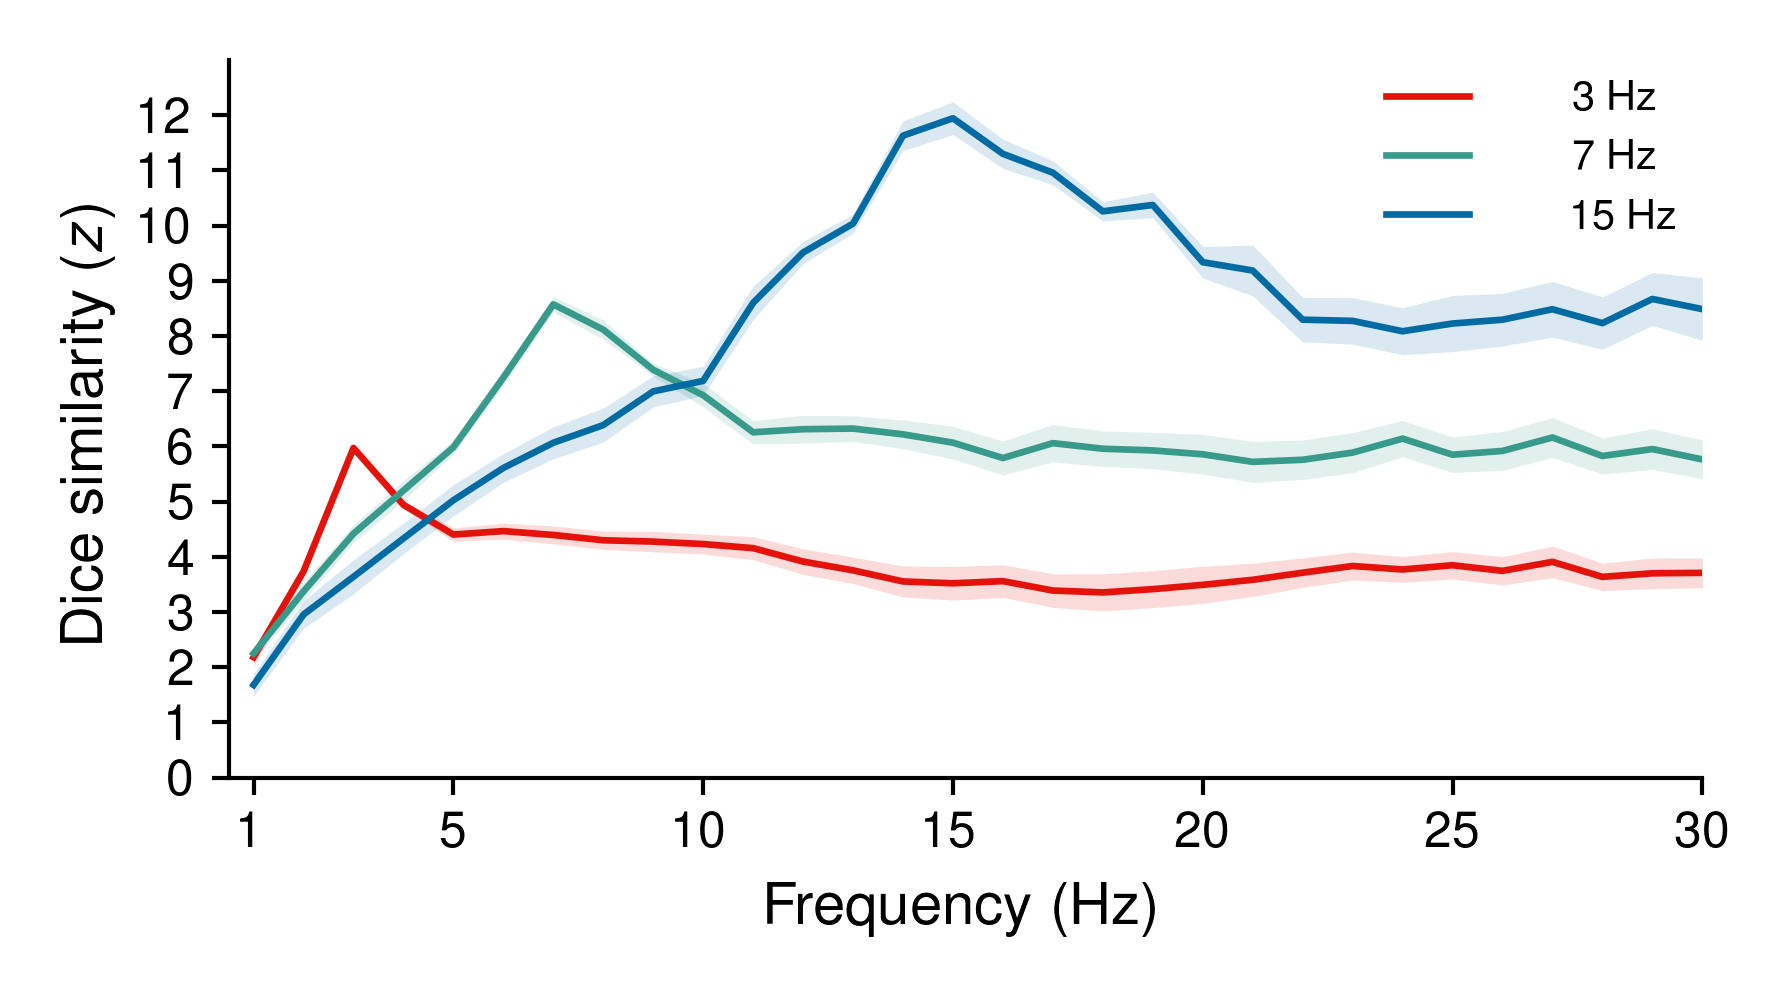

In [220]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(ax_linewidth)
ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=font['tick'])
ax.set_xlabel('Frequency (Hz)', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel(r'Dice similarity (\textit{z})', fontsize=font['label'], labelpad=labelpad)
for vals, color, label in zip([dicez3a, dicez7a, dicez15a], ['#E3120B',  '#379A8B', '#006BA2'], ['3 Hz', '7 Hz', '15 Hz']):
    line, = ax.plot(freqs, vals['mean'].to_numpy(),color=color)
    ax.fill_between(freqs, vals['upper'].to_numpy(), vals['lower'].to_numpy(), alpha=0.15, lw=0, color=color)
    line.set_label(label)
ax.legend(fontsize=5)

In [221]:
mpl.rc('text', usetex=False)

## First three bouts

In [26]:
slistchanHPCcooc = load_pickle('/home1/amrao/SUPL/files/oscillation_detection/slistchanHPCcooc.pkl')

In [27]:
meanb_df = slistchanHPCcooc[['sub', 'sess', 'chan', 'reg', 'meanb_3', 'meanb_7', 'meanb_15']].copy()
meanb_3 = meanb_df.groupby(['sub', 'sess', 'reg']).meanb_3.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean().mean()
meanb_7 = meanb_df.groupby(['sub', 'sess', 'reg']).meanb_7.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean().mean()
meanb_15 = meanb_df.groupby(['sub', 'sess', 'reg']).meanb_15.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean().mean()

In [28]:
is_local = 0
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 10, 'label': 10, 'fig': 8, 'annot': 6}
ax_linewidth = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0, 1]
xticks = [np.round(x, 1) if int(x)!=x else int(x) for x in np.arange(0, len(meanb_3)/1000+0.01, 0.2)]
xticklabs = xticks
ylim = (0, 2)
yticks = np.arange(-300, 301, 150)
yticklabs = yticks
lw = 1
plot_hline = 1
hline = 0
hline_color = co['k']
plot_labels = False

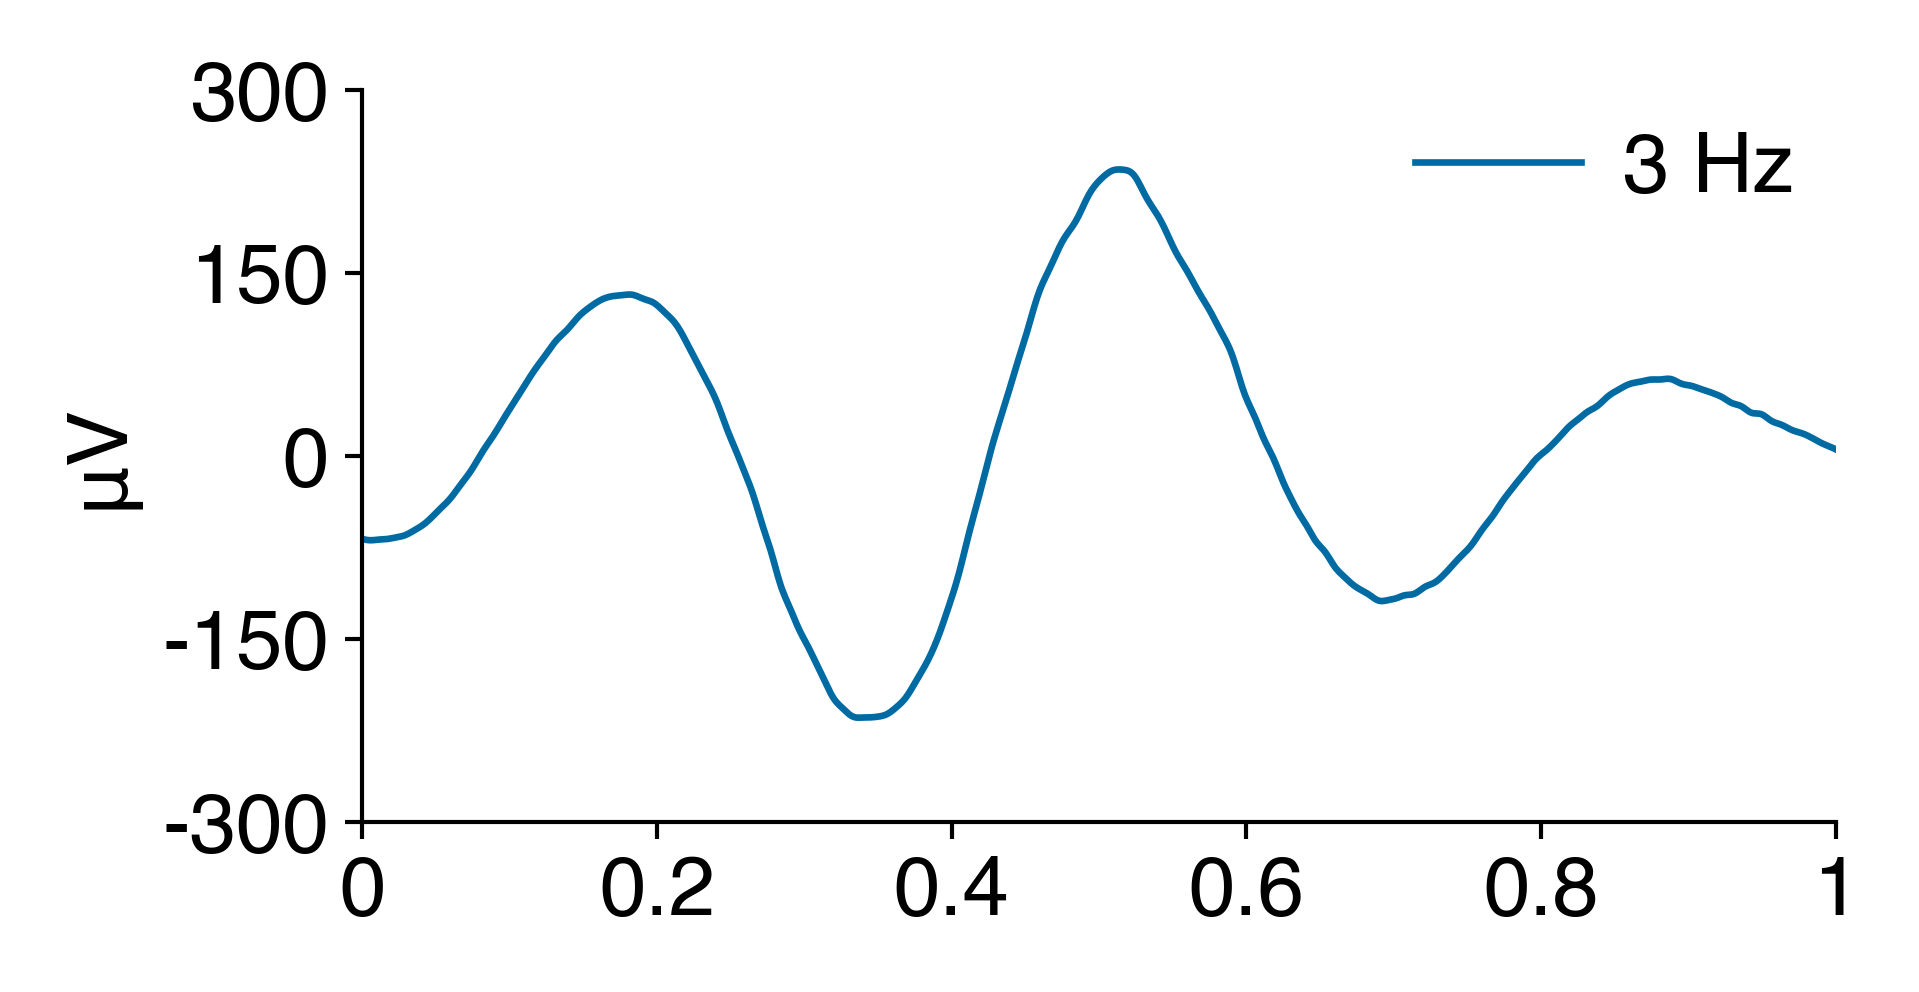

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(ax_linewidth)
ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
#ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('μV', fontsize=font['label'], labelpad=labelpad)
line, = ax.plot(np.arange(.001, 1.0001, 0.001), meanb_3, color='#006BA2', linestyle='solid')
line.set_label('3 Hz')
ax.legend(fontsize=10, handletextpad=0.5)

In [30]:
is_local = 0
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 10, 'label': 10, 'fig': 8, 'annot': 6}
ax_linewidth = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0, 0.45]
xticks = np.arange(0, len(meanb_7)/1000+0.05, 0.1)
xticks = [np.round(x, 2) if int(x)!=x else int(x) for x in xticks]
xticklabs = xticks
ylim = (0, 1)
yticks = np.arange(-300, 301, 150)
yticklabs = yticks
lw = 1
plot_hline = 1
hline = 0
hline_color = co['k']
plot_labels = False

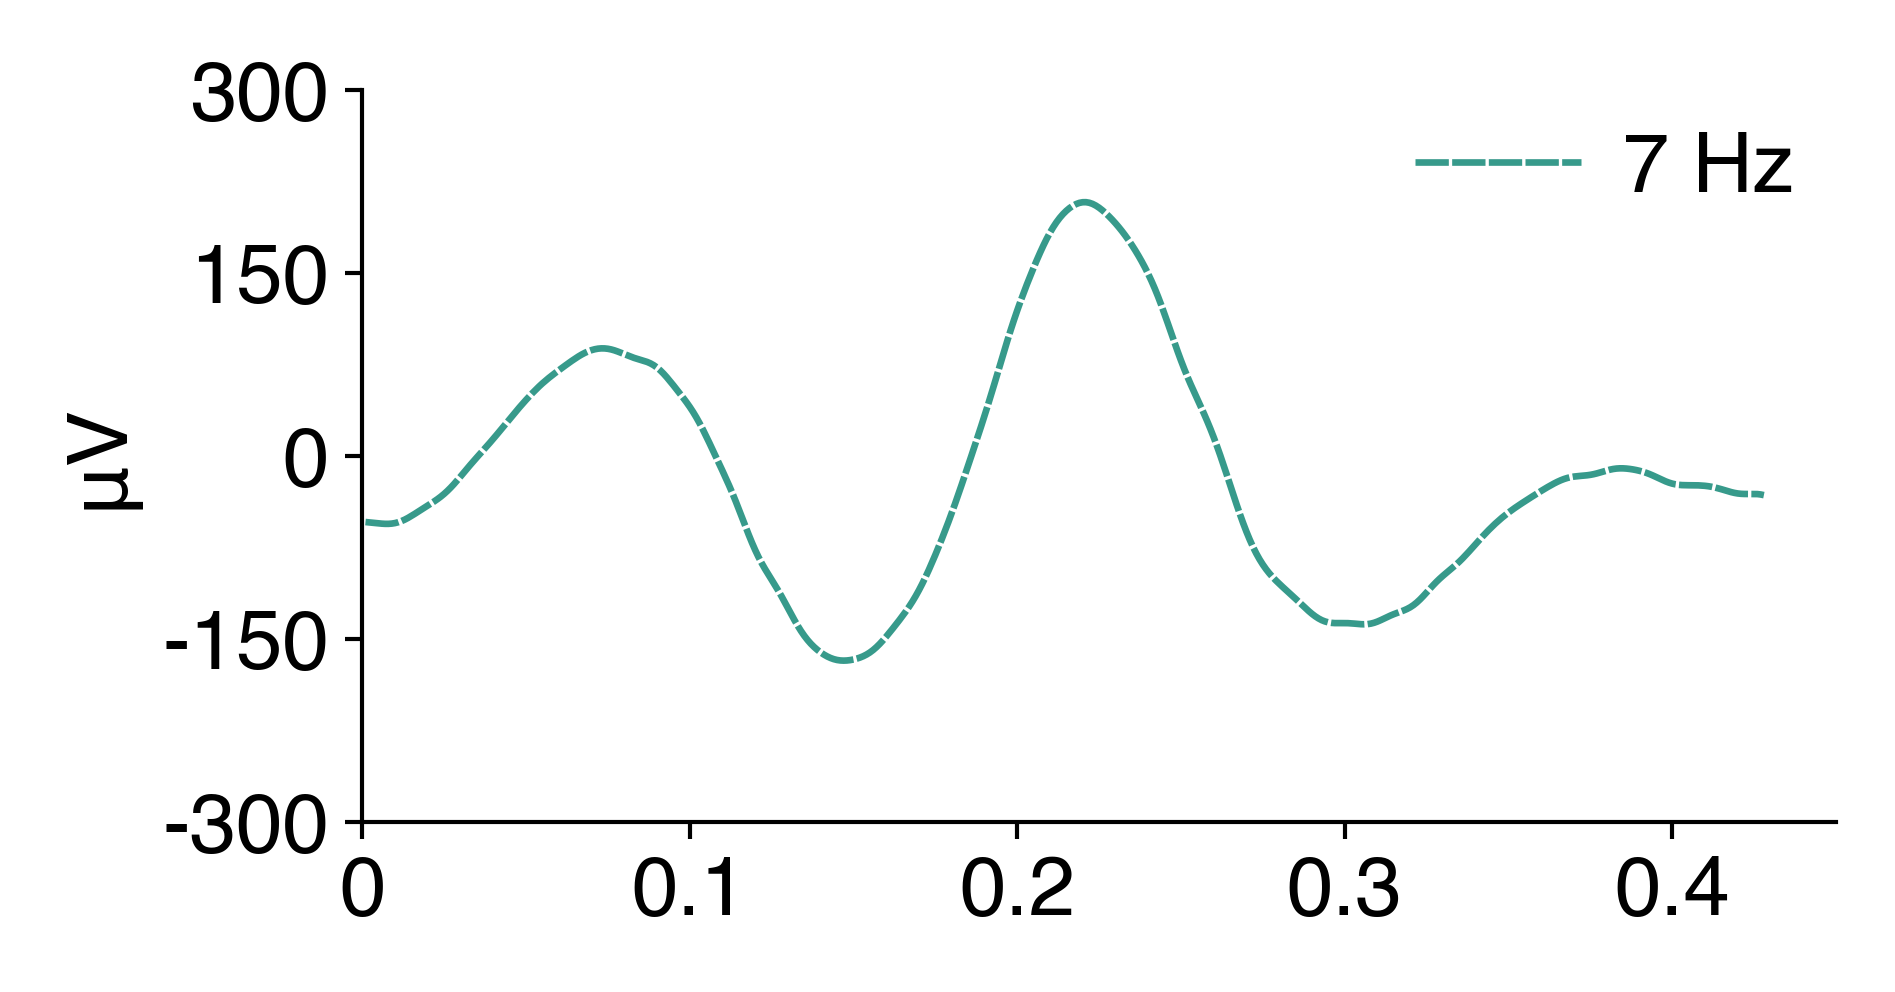

In [31]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(ax_linewidth)
ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
#ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('μV', fontsize=font['label'], labelpad=labelpad)
line, = ax.plot(np.arange(.001, len(meanb_7)*.001+.001, 0.001), meanb_7,color='#379A8B', linestyle=(0, (5, 0.5)))
line.set_label('7 Hz')
ax.legend(fontsize=10, handletextpad=0.5)

In [32]:
is_local = 0
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 10, 'label': 10, 'fig': 8, 'annot': 6}
ax_linewidth = 0.5
labelpad = 3
ticklen = 2
tickpad = 2
xvals = np.arange(1, 31)
xlim = [0, 0.2]
xticks = np.arange(0, len(meanb_15)/1000+0.01, 0.05)
xticks = [np.round(x, 2) if int(x)!=x else int(x) for x in xticks]
xticklabs = xticks
ylim = (0, 1)
yticks = np.arange(-300, 301, 150)
yticklabs = yticks
lw = 1
plot_hline = 1
hline = 0
hline_color = co['k']
plot_labels = False

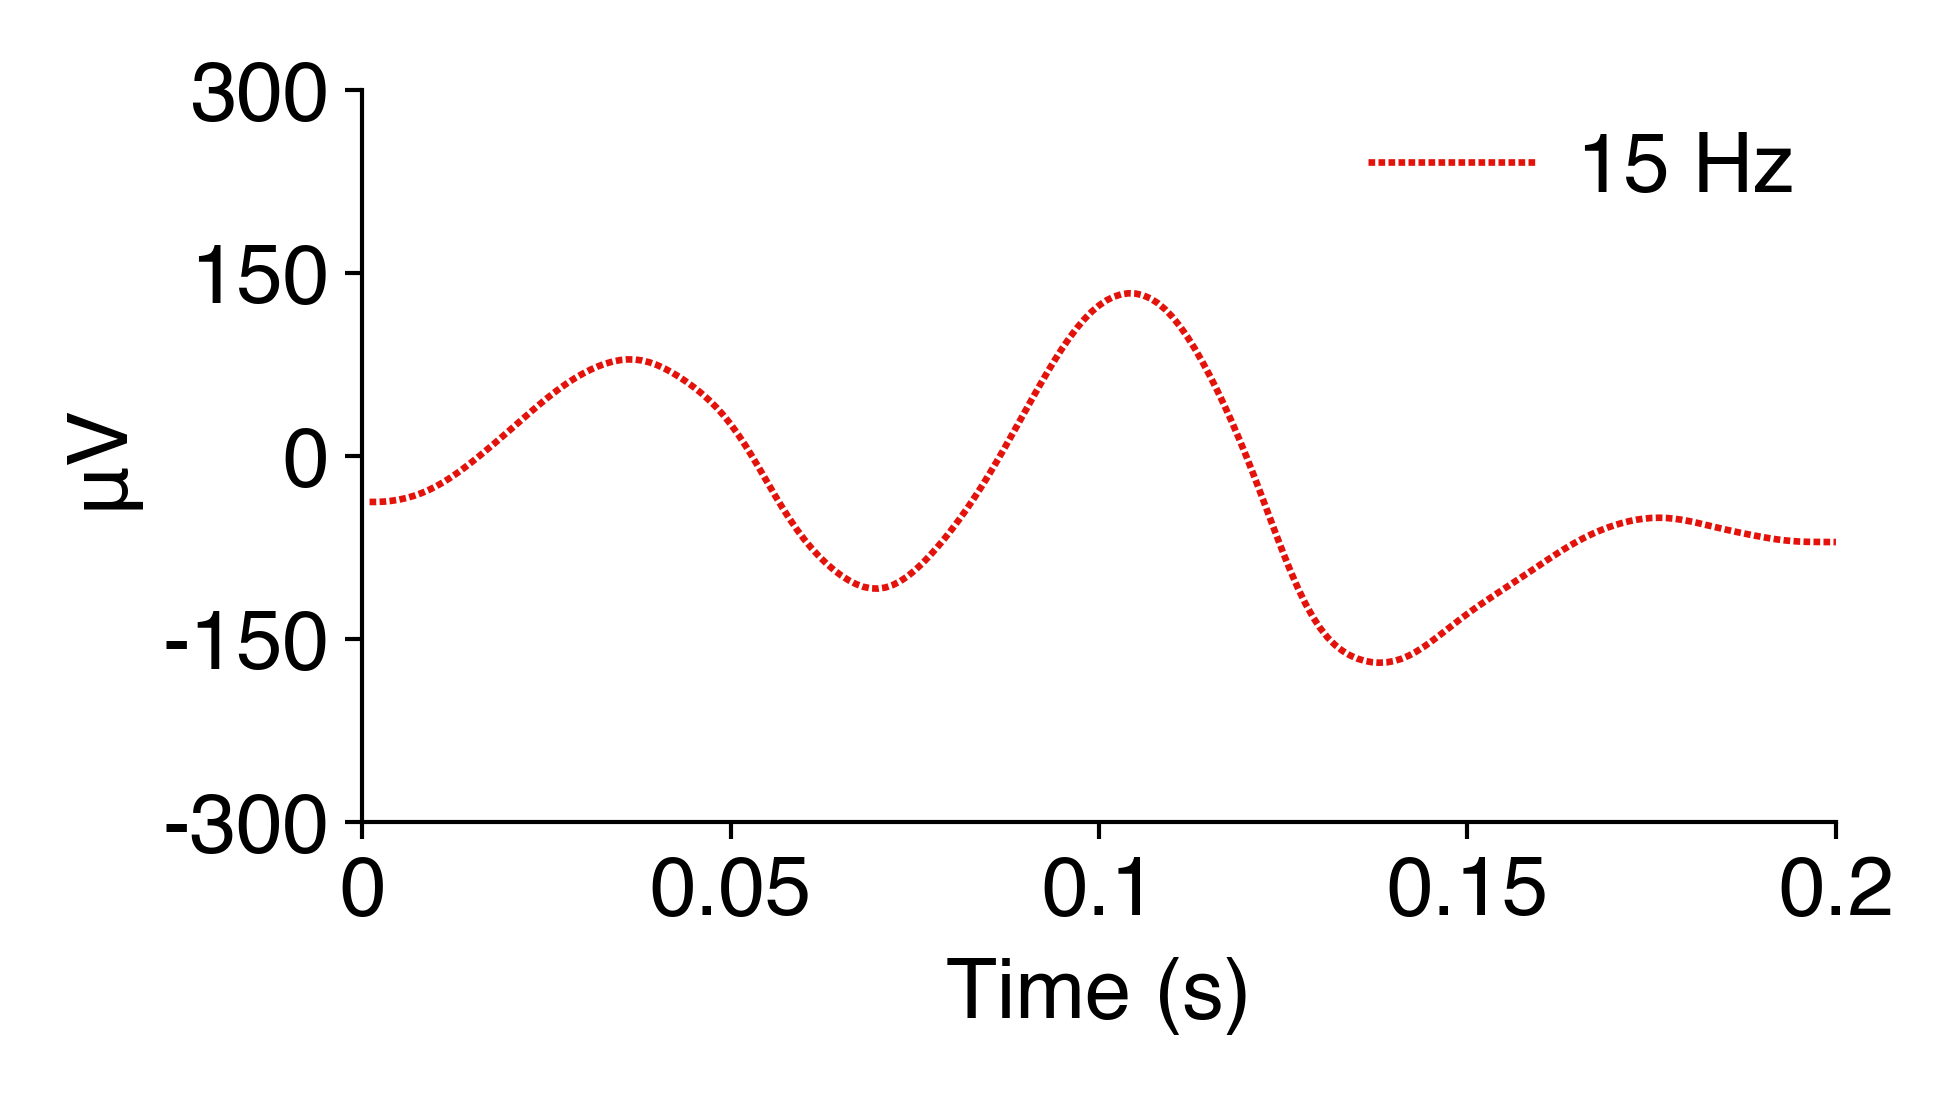

In [33]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(ax_linewidth)
ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=ax_linewidth)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=font['tick'])
ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('μV', fontsize=font['label'], labelpad=labelpad)
line, = ax.plot(np.arange(.001, len(meanb_15)*.001+.001, 0.001), meanb_15,color='#E3120B',linestyle=(0, (1, 0.5)))
line.set_label('15 Hz')
ax.legend(fontsize=10, handletextpad=0.5)

## Asymmetry bar plot

In [194]:
slistchanHPCcooc = load_pickle('/home1/amrao/SUPL/files/oscillation_detection/slistchanHPCcooc.pkl')

In [195]:
ai_df = slistchanHPCcooc[['sub', 'sess', 'chan', 'reg', 'ai_osc_3', 'ai_osc_7', 'ai_osc_15']].copy()
ai_3 = ai_df.groupby(['sub', 'sess', 'reg']).ai_osc_3.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean()
ai_7 = ai_df.groupby(['sub', 'sess', 'reg']).ai_osc_7.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean()
ai_15 = ai_df.groupby(['sub', 'sess', 'reg']).ai_osc_15.mean().groupby(['sub', 'sess']).mean().groupby('sub').mean()

In [196]:
ai_3 = ai_3.to_numpy()
ai_7 = ai_7.to_numpy()
ai_15 = ai_15.to_numpy()

In [198]:
ai_3 = mean_sem(ai_3)
ai_7 = mean_sem(ai_7)
ai_15 = mean_sem(ai_15)

In [199]:
ai = pd.concat([ai_3, ai_7, ai_15]).reset_index(drop=True)
ai.insert(0, 'freq', [3, 7, 15])

In [200]:
lower = ai.apply(lambda x: np.abs(x['mean']-x['lower']), axis=1).to_numpy()
upper = ai.apply(lambda x: np.abs(x['mean']-x['upper']), axis=1).to_numpy()
yerr = np.vstack([lower, upper])

Text(0, 0.5, 'Asymmetry index')

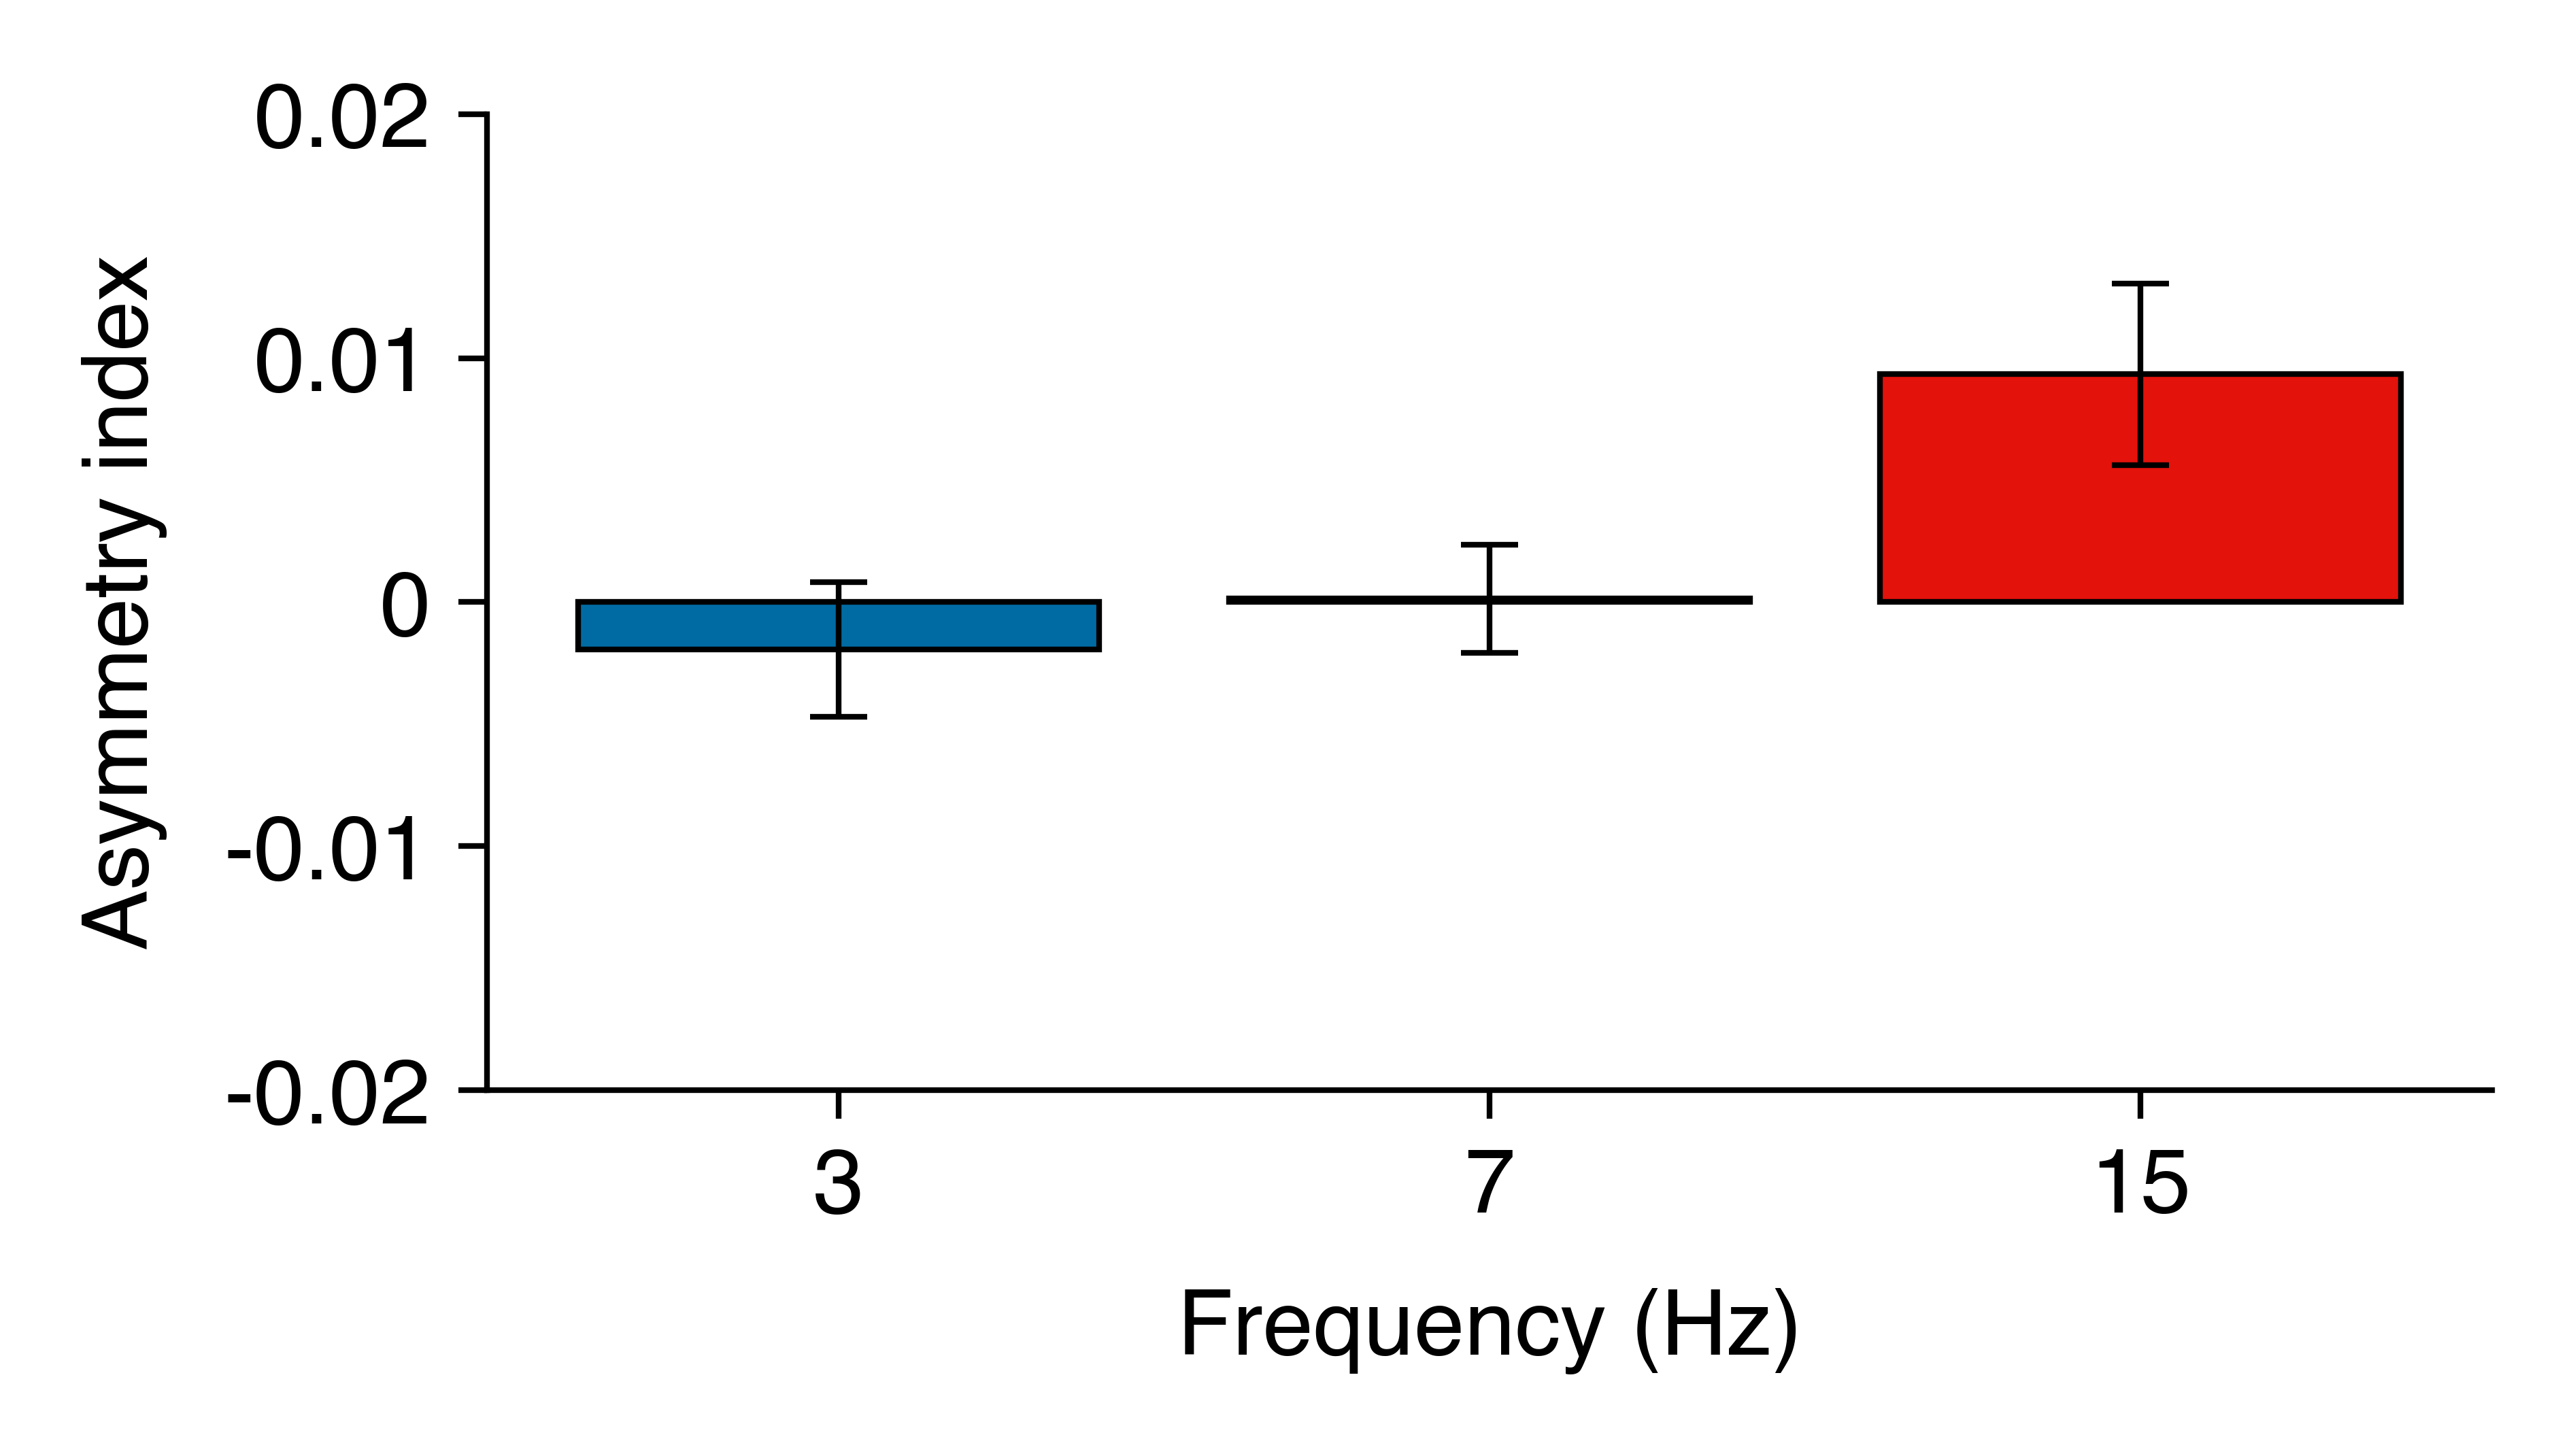

In [201]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 8, 'label': 8, 'fig': 10, 'annot': 7}
ymin = -0.02
ymax = 0.02
yticks = [np.round(x, 3) if int(x)!=x else int(x) for x in np.arange(-0.02, 0.02+0.00001, 0.01)]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']
palette = ['#006BA2', '#379A8B', '#E3120B']
freqs = [3, 7, 15]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
_ax.axhline(5, lw=spine_lw, color=hline_color, ls='--')
_ax = sns.barplot(x='freq', y='mean', data=ai, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar=None, lw=spine_lw, ec='k',)

_ax.errorbar(np.arange(len(freqs)),
             ai['mean'].to_numpy(),
             yerr=yerr,
             ecolor='k', elinewidth=spine_lw, capsize=capsize,
             capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(freqs)))
_ax.set_xticklabels(freqs, fontsize=font['tick'])
_ax.set_xlabel('Frequency (Hz)')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('Asymmetry index', fontsize=font['label'], labelpad=labelpad)